# <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">Building Random Forest Scorecards</span> </center>

 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_tree

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Synthetic credit risk dataset</span>

In [2]:
# Generate a synthetic dataset
X, y = make_classification(
    n_samples=50000, n_features=15, n_classes=2, n_informative=5, random_state=42
)

X, y = pd.DataFrame(X), pd.DataFrame(y)

X.columns = [f"feature_{i+1}" for i in range(len(X.columns))]

ix_train, ix_test = train_test_split(X.index, stratify=y, random_state=62)

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Model training</span>

In [3]:
# Create an XGBoost model with two tree iterations
model_gbdt = xgb.XGBClassifier(
    booster="gbtree",
    n_estimators=5, # random forests
    max_depth=2, # keep at 2 for low complexity
    subsample=0.5,
    colsample_bynode=0.2,
    num_parallel_tree=2, # trees per forest
    eval_metric="logloss", # loss metric
)

evalset = [(X.loc[ix_train], y.loc[ix_train]), (X.loc[ix_test], y.loc[ix_test])]

# Fit the model to the generated dataset
model_gbdt.fit(X.loc[ix_train], y.loc[ix_train], eval_set=evalset)

# Make predictions using the model with two tree iterations
predictions_gbdt_trn = model_gbdt.predict_proba(X.loc[ix_train])[:, 1]
predictions_gbdt_val = model_gbdt.predict_proba(X.loc[ix_test])[:, 1]

auc_gbdt_trn = roc_auc_score(y.loc[ix_train], predictions_gbdt_trn)
auc_gbdt_val = roc_auc_score(y.loc[ix_test], predictions_gbdt_val)

print(f"Train Gini score: {auc_gbdt_trn*2-1:.2%}\nTest Gini score: {auc_gbdt_val*2-1:.2%}")

[0]	validation_0-logloss:0.65927	validation_1-logloss:0.65907
[1]	validation_0-logloss:0.61833	validation_1-logloss:0.61752
[2]	validation_0-logloss:0.58179	validation_1-logloss:0.58069
[3]	validation_0-logloss:0.55676	validation_1-logloss:0.55552
[4]	validation_0-logloss:0.54367	validation_1-logloss:0.54248
Train Gini score: 74.58%
Test Gini score: 74.65%


### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Decomposing trees</span>

In [4]:
from scipy.special import expit as sigmoid, logit as inverse_sigmoid

In [5]:
# check how many trees are trained
booster_ = model_gbdt.get_booster()
num_trees = booster_.best_iteration + 1
print(f"Total number of trees in the final model: {num_trees}")

# get a dump
booster_dump = booster_.get_dump()
num_trees_dump = len(booster_dump)
print(f"Total number of trees used in estimation: {num_trees_dump}")

Total number of trees in the final model: 5
Total number of trees used in estimation: 10


In [6]:
# Extract indivudual predictions
individual_preds = []
for tree_ in booster_:
    individual_preds.append(tree_.predict(xgb.DMatrix(X.loc[ix_test][0:1])))

# predictions from individual trees
individual_preds = np.vstack(individual_preds)

# Aggregated individual predictions to final predictions
indivudual_logits = inverse_sigmoid(individual_preds)
final_logits = indivudual_logits.sum(axis=0)
final_preds = sigmoid(final_logits)

# Verify correctness
xgb_preds = booster_.predict(xgb.DMatrix(X.loc[ix_test][0:1]))
np.testing.assert_almost_equal(final_preds, xgb_preds)

In [7]:
print(individual_preds.T)       # predictions from each tree
print(final_preds, xgb_preds)   # final model predictions

[[0.4692527  0.54577607 0.5613101  0.5526892  0.48897016]]
[0.61641765] [0.6164176]


In [8]:
tree_dict = {"iter": [], "pred": [], "pred_proba": []}

n_rounds = booster_.best_iteration+1

for tree_limit in range(0, n_rounds):
    pred = booster_.predict(
        xgb.DMatrix(X.loc[ix_test][0:1]), iteration_range=(tree_limit, tree_limit + 1)
    )
    pred_proba = model_gbdt.predict_proba(
        X.loc[ix_test][0:1], iteration_range=(tree_limit, tree_limit + 1)
    )[:, 1]
    tree_dict["iter"].append(tree_limit)
    tree_dict["pred"].append(pred)
    tree_dict["pred_proba"].append(pred_proba)

display(np.array(tree_dict["pred"]).T)
# display(np.array(tree_dict['pred_proba']).T)

array([[0.4692527 , 0.54577607, 0.5613101 , 0.5526892 , 0.48897016]],
      dtype=float32)

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Parsing Random Forest models</span>

In [9]:
# Class for tree parsing
class TreeParser:
    def __init__(self, booster):
        self.booster = booster

    def parse_trees(self) -> pd.DataFrame:
        # Transform booster into a DataFrame
        booster_df = self.booster.trees_to_dataframe()

        # Filter root and split
        root_df = booster_df[
            (booster_df["Feature"] != "Leaf") & (booster_df["ID"].str[-1:] == "0")
        ]

        split_df = booster_df[
            (booster_df["Feature"] != "Leaf") & (booster_df["ID"].str[-1:] != "0")
        ]

        # Filter leaves
        leaf_df = booster_df[booster_df["Feature"] == "Leaf"]

        # Merge branches
        braches_left = (
            pd.merge(
                root_df[["Tree", "Feature", "Split", "Yes"]].rename(
                    {
                        "Tree": "Tree_ID",
                        "Feature": "Root_feature",
                        "Split": "Root_split",
                    },
                    axis=1,
                ),
                split_df[["ID", "Split", "Feature"]].rename(
                    {"Feature": "Split_feature", "Split": "Split_ID", "ID": "Root_ID"},
                    axis=1,
                ),
                left_on="Yes",
                right_on="Root_ID",
                how="left",
            )
            .assign(Root_sign="<")
            .drop(columns="Yes")
        )

        braches_right = (
            pd.merge(
                root_df[["Tree", "Feature", "Split", "No"]].rename(
                    {
                        "Tree": "Tree_ID",
                        "Feature": "Root_feature",
                        "Split": "Root_split",
                    },
                    axis=1,
                ),
                split_df[["ID", "Split", "Feature"]].rename(
                    {"Feature": "Split_feature", "Split": "Split_ID", "ID": "Root_ID"},
                    axis=1,
                ),
                left_on="No",
                right_on="Root_ID",
                how="left",
            )
            .assign(Root_sign=">=")
            .drop(columns="No")
        )

        branches = pd.concat([braches_left, braches_right], axis=0)

        # Merge leaves
        left_child = (
            pd.merge(
                split_df[["Tree", "Feature", "Split", "Yes"]],
                leaf_df[["ID", "Gain"]],
                left_on="Yes",
                right_on="ID",
                how="left",
            )
            .assign(Sign="<")
            .dropna()
            .drop(columns="Yes")
        )

        right_child = (
            pd.merge(
                split_df[["Tree", "Feature", "Split", "No"]],
                leaf_df[["ID", "Gain"]],
                left_on="No",
                right_on="ID",
                how="left",
            )
            .assign(Sign=">=")
            .dropna()
            .drop(columns="No")
        )

        leaves = pd.concat([left_child, right_child], axis=0)
        leaves.sort_values(by=["Tree", "ID", "Sign"], inplace=True)

        # Join branches and leaves
        parsed_tree = pd.merge(
            branches[
                [
                    "Tree_ID",
                    "Root_feature",
                    "Root_split",
                    "Root_sign",
                    "Root_ID",
                    "Split_ID",
                    "Split_feature",
                ]
            ],
            leaves[["Tree", "Feature", "Split", "ID", "Sign", "Gain"]],
            left_on=["Tree_ID", "Split_feature", "Split_ID"],
            right_on=["Tree", "Feature", "Split"],
            how="left",
        )

        return parsed_tree

In [10]:
parsed_tree = TreeParser(booster_).parse_trees()

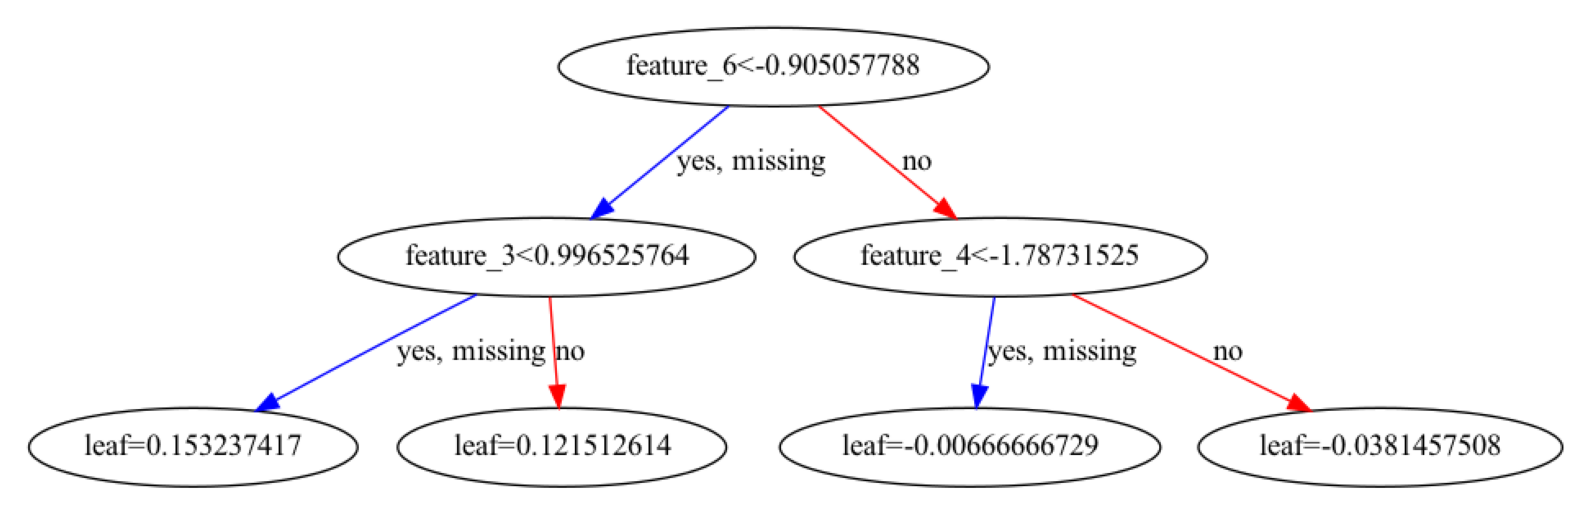

In [11]:
plot_tree(model_gbdt, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(10, 15)

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Tree predictions</span>

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [13]:
# Class for predicting with Random Forest trees
class TreePredictions(BaseEstimator, TransformerMixin):
    def fit(self, X=None, y=None):
        return self

    def transform(self, parsed_tree: pd.DataFrame, data: pd.DataFrame) -> pd.DataFrame:
        tree_ids = parsed_tree["Tree_ID"].unique()
        leaf_values_dict = {
            f"Tree_{tree_id+1}": np.zeros(len(data)) for tree_id in tree_ids
        }

        for _, row in parsed_tree.iterrows():
            root_feature = row["Root_feature"]
            split_feature = row["Split_feature"]
            root_sign = row["Root_sign"]
            root_split = row["Root_split"]
            sign = row["Sign"]
            split = row["Split"]
            gain = row["Gain"]
            tree_id = row["Tree_ID"]

            if root_sign == "<":
                root_condition = (data[root_feature] < root_split).astype(int)
            elif root_sign == ">=":
                root_condition = (data[root_feature] >= root_split).astype(int)

            if sign == "<":
                condition = (data[split_feature] < split).astype(int)
            elif sign == ">=":
                condition = (data[split_feature] >= split).astype(int)

            true_condition = (root_condition == 1) & (condition == 1)

            leaf_values_dict[f"Tree_{tree_id+1}"] += true_condition * gain

        leaf_values_df = pd.DataFrame(leaf_values_dict)
        return leaf_values_df

In [14]:
tree_predictions = TreePredictions()
leaf_values_df = tree_predictions.transform(parsed_tree, X.loc[ix_test][0:1])

In [15]:
display(leaf_values_df)
display(sigmoid(leaf_values_df))

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10
16652,-0.038146,-0.084999,0.178534,0.005084,0.231082,0.015399,0.128421,0.083121,0.016304,-0.06043


,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10
16652,0.490465,0.478763,0.544515,0.501271,0.557515,0.50385,0.532061,0.520768,0.504076,0.484897


### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Consistency</span>

In [16]:
# Initialize a list to store the margins
margins = []

for i in range(n_rounds):
    margin = leaf_values_df[f"Tree_{2*i+1}"] + leaf_values_df[f"Tree_{2*i+2}"]
    probability = round(sigmoid(margin).item(), 6)
    margins.append(probability)

print(margins)
print([round(x[0].item(), 6) for x in tree_dict["pred"]])

[0.469253, 0.545776, 0.56131, 0.552689, 0.48897]
[0.469253, 0.545776, 0.56131, 0.552689, 0.48897]


### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Random Forest scorecard</span>

In [23]:
from typing import Dict, List

In [24]:
parsed_tree_scorecard = parsed_tree.copy().rename({'Gain': 'XAddEvidence'}, axis=1)

In [25]:
def setup_scorecard(scorecard, PDO=50, standardSc_pts=500, standardSc_odds=19, pts_dec_prec=0, base_rate=0.5):
    """Append 'Points' field to a scorecard dataframe

    Parameters
    ----------
    scdf : DataFrame
        A scorecard dataframe
    PDO : int, float, optional (default=20)
        Points to double odds - number of points needed for the outcome odds to double
    standardSc_pts : int, float, optional (default=500)
        Standard score points - a fixed point on the points scale with fixed odds 
    standardSc_odds : int, float, optional (default=19)
        Standard Odds - odds of good at standard score fixed point
    pts_dec_prec : int, optional (default=1)
        Decimal places to show in scorecard points 
    trndict : dictionary, optional (default=None)
        The output of woesc.describe_data_g_targ(trndat, targ_var)

    Returns
    -------
    pointscard : DataFrame
        The input scorecard with points column appended
    """

    scdf = scorecard.copy()
    scdf['Score'] = scdf.XAddEvidence.values
    scdf.base_score = base_rate
    
    factor = PDO / np.log(2)
    offset = standardSc_pts - factor * np.log(standardSc_odds)

    scdf['sclSc'] = factor * scdf.Score

    var_offsets = scdf.groupby(by=['Tree'])['sclSc'].max().reset_index()
    tmp_sclSc = scdf[['Tree', 'sclSc', 'ID']].copy().rename({'sclSc': 'score'}, axis=1)
    shftSc =  abs(tmp_sclSc['score'] - scdf['sclSc'].max())
     
    pointscard = scdf.copy()

    pointscard['Points'] = shftSc.round(pts_dec_prec).values
    shft_base_pts = (offset - var_offsets.sum()).round(pts_dec_prec)

    if (pts_dec_prec <= 0):
        pointscard['Points'] = pointscard.Points.astype(int)
        shft_base_pts = shft_base_pts.astype(int)
    
    return pointscard

In [26]:
scorecard = setup_scorecard(parsed_tree_scorecard, base_rate = y.loc[ix_train].mean().item())
predictions = tree_predictions.transform(parsed_tree, X.loc[ix_test])

In [27]:
# perform score mapping
tree_mapping = {}

# Loop through each unique Tree_ID in the scorecard
for tree_id in scorecard['Tree_ID'].unique():
    tree_scorecard = scorecard[scorecard['Tree_ID'] == tree_id]
    
    tree_mapping[tree_id] = (
        tree_scorecard
        .groupby('XAddEvidence')['Points']
        .max()
        .reindex(predictions[f'Tree_{tree_id + 1}'])
        .fillna(0)  # Replace missing values with 0
        .values
    )

# Initialize an empty DataFrame to store the results
scores = pd.DataFrame(index=predictions.index)

# Loop through each unique Tree_ID in the scorecard
for tree_id in scorecard['Tree_ID'].unique():
    tree_column_name = f"Tree_{tree_id + 1}"
    
    # Map the values from the predictions DataFrame using the mapping dictionary
    scores[f"Score_{tree_column_name}"] = tree_mapping[tree_id]
    
scores['Score'] = scores.sum(axis=1)

In [28]:
cols_to_show = ['Tree', 'Feature', 'Sign', 'Split', 'XAddEvidence', 'Points']
scorecard[scorecard.index < 8][cols_to_show]

,Tree,Feature,Sign,Split,XAddEvidence,Points
0,0,feature_3,<,0.996526,0.153237,6
1,0,feature_3,>=,0.996526,0.121513,8
2,1,feature_13,<,0.289962,-0.084999,23
3,1,feature_13,>=,0.289962,0.195884,3
4,2,feature_14,<,-0.556087,0.178534,4
5,2,feature_14,>=,-0.556087,-0.042278,20
6,3,feature_2,<,0.037487,-0.133542,26
7,3,feature_2,>=,0.037487,0.005084,16


### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Performance of scorecards</span>

In [29]:
from matplotlib.font_manager import FontProperties

In [30]:
predictions = tree_predictions.transform(parsed_tree, X.loc[ix_test])
predictions['Model'] = predictions.sum(axis=1)

predictions = pd.concat(
    [predictions, y.loc[ix_test]],
    axis=1).rename(
        {0:'is_bad'}, axis=1)

gini_dict = {'Tree': [], 'Gini score': []}
for col in predictions.drop(columns='is_bad').columns:
    gini_score = roc_auc_score(predictions['is_bad'], predictions[col])*2-1
    gini_dict['Tree'].append(col.replace("_", " "))
    gini_dict['Gini score'].append(gini_score)

gini_df = pd.DataFrame(gini_dict)
gini_df['Gini score'] = gini_df['Gini score'].astype(float)

In [31]:
ginis = gini_df['Gini score'].to_list()
colors = [
    {
        p<0.30: 'salmon', 
        0.30<=p<=0.5: 'orange', 
        p>0.5: 'teal'
    }[True] for p in ginis]

fig = plt.figure(figsize=(8, 5), dpi=600)


custom_font = FontProperties(fname="Fonts/Virgil-GS-Regular.ttf")
custom_hatch_colors = [colors[i % len(colors)] for i in range(len(ginis))]

bars = plt.bar(
    gini_df['Tree'],
    gini_df['Gini score'],
    edgecolor=custom_hatch_colors,
    hatch='///',
    fill=False,
    linewidth=2.0,
    width=0.85
)

plt.title('Gini scores of scorecard components', fontproperties=custom_font, fontsize=20)
plt.gca().get_yaxis().set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

for i, v in enumerate(gini_df['Gini score']):
    plt.text(
        i, v, 
        f"{v:.0%}", 
        ha='center', va='bottom', 
        fontproperties=custom_font,
        fontsize=12)

plt.xticks(rotation=45, fontproperties=custom_font, fontsize=12)
plt.tight_layout()
plt.show()

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Most predictive components</span>

In [32]:
scores_df = pd.concat(
    [scores, y.loc[ix_test]],
    axis=1).rename(
        {0:'is_bad'}, axis=1)

testing_df = scores_df[['Score_Tree_4', 'Score_Tree_5', 'Score_Tree_8', 'is_bad']].copy()
target_v = testing_df.pop('is_bad')
testing_df['Score'] = testing_df.sum(axis=1)
gini_score = roc_auc_score(target_v, -testing_df['Score'])*2-1
max_gini = gini_df['Gini score'].max()
print(f"Gini score with best components: {gini_score:.2%}\n% of full model Gini: {gini_score/max_gini:.2%}")

Gini score with best components: 70.03%
% of full model Gini: 93.82%
